# MobileNet Using Transfer Learning

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [2]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
direct = '/home/abdalla/Datasets/Alpaca/'

In [3]:
train_dataset = image_dataset_from_directory(
    directory= direct,
    batch_size= BATCH_SIZE,
    image_size= IMG_SIZE,
    shuffle= True,
    subset= 'training',
    validation_split= 0.2,
    seed = 0
)

Found 327 files belonging to 2 classes.
Using 262 files for training.


In [4]:
val_dataset = image_dataset_from_directory(
    directory= direct,
    batch_size= BATCH_SIZE,
    image_size= IMG_SIZE,
    shuffle= True,
    subset= 'validation',
    validation_split= 0.2,
    seed = 0
)

Found 327 files belonging to 2 classes.
Using 65 files for validation.


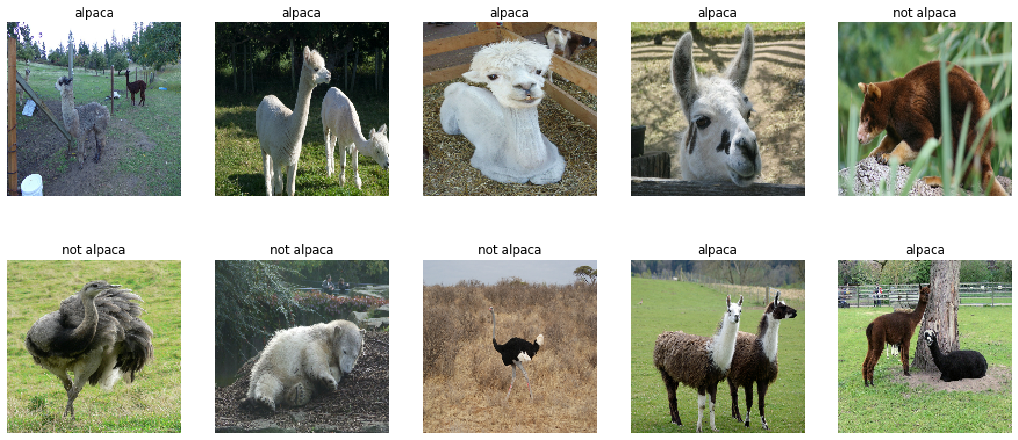

In [5]:
classes = train_dataset.class_names

plt.figure(figsize=(18, 8))
for images, labels in train_dataset.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

In [6]:
AUTO = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(AUTO)

In [7]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    
    data_augment = keras.Sequential()
    data_augment.add(RandomFlip('horizontal'))
    data_augment.add(RandomRotation(0.2))
    
    return data_augment

In [8]:
image_process = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
def mobileNetwork(img_shape=IMG_SIZE, data_augmenter=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = img_shape + (3,)
    
    # get the base model
    base_model = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet')
    
    # Freeze the base model
    base_model.trainable = False
    
#     for layer in base_model.layers[140:]:
#         layer.trainable=True
    
    input_layer = tfl.Input(input_shape)
    
    X = data_augmenter(input_layer)
    
    X = image_process(X)
    
    X = base_model(X, training=False)
    
    X = tfl.GlobalAvgPool2D()(X)
    
    X = tfl.Dropout(0.2)(X)
    
    output_layer = tfl.Dense(1)(X)
    
    return keras.Model(input_layer, output_layer)

In [10]:
model = mobileNetwork()

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
             )

In [12]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
9/9 [==============================] - 7s 402ms/step - loss: 5.8680 - accuracy: 0.5113 - val_loss: 5.8781 - val_accuracy: 0.6154
Epoch 2/5
9/9 [==============================] - 4s 309ms/step - loss: 6.5825 - accuracy: 0.5430 - val_loss: 5.8654 - val_accuracy: 0.6154
Epoch 3/5
9/9 [==============================] - 4s 304ms/step - loss: 6.3057 - accuracy: 0.5578 - val_loss: 5.6667 - val_accuracy: 0.6000
Epoch 4/5
9/9 [==============================] - 4s 305ms/step - loss: 5.9500 - accuracy: 0.5734 - val_loss: 3.9711 - val_accuracy: 0.6308
Epoch 5/5
9/9 [==============================] - 4s 320ms/step - loss: 4.6888 - accuracy: 0.6109 - val_loss: 4.5700 - val_accuracy: 0.6769


In [13]:
base_model = model.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(0.1*0.001)
# Use accuracy as evaluation metric
metrics=['accuracy']

model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [14]:
fine_tune_epochs = 5
total_epochs =  5 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 5/10
9/9 [==============================] - 8s 473ms/step - loss: 0.9355 - accuracy: 0.5731 - val_loss: 0.5749 - val_accuracy: 0.5692
Epoch 6/10
9/9 [==============================] - 5s 398ms/step - loss: 0.4870 - accuracy: 0.6643 - val_loss: 0.4115 - val_accuracy: 0.8462
Epoch 7/10
9/9 [==============================] - 5s 373ms/step - loss: 0.4722 - accuracy: 0.7820 - val_loss: 0.3139 - val_accuracy: 0.8615
Epoch 8/10
9/9 [==============================] - 5s 374ms/step - loss: 0.3381 - accuracy: 0.8789 - val_loss: 0.3801 - val_accuracy: 0.7385
Epoch 9/10
9/9 [==============================] - 5s 368ms/step - loss: 0.2597 - accuracy: 0.8496 - val_loss: 0.3270 - val_accuracy: 0.7692
Epoch 10/10
9/9 [==============================] - 5s 369ms/step - loss: 0.2302 - accuracy: 0.8876 - val_loss: 0.3514 - val_accuracy: 0.8154


# Done :D